### Pairs Trading - Correlation

**Motivation:**
- Security A - (Something Correlated to it) is more mean-reverting. Similar securties should trade similarily. Hence, any discrepancies between the correlated pairs should converge
- When there is a discrepancy, we form a long-short spread trade and bet on the discrepancy converging
- Pairs trading is one of the most popular statistical arbitrage strategies in traditional markets. We want to test the performance of this strategy in the cryptocurrency market, as it is still relatively new and should be fertile grounds for finding market inefficiencies
- While cointegration is a robust statistical method for identifying long-term relationships, Correlation is simpler and more responsive to short-term relationships, making it suitable for the fast-moving cryptocurrency market.

In [1]:
from datetime import datetime
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from itertools import combinations

### Data
We selected the top 1,000 currencies sorted by volume from CoinGecko. Then, we filtered out coins with fewer than 90% of daily price data points between 2018 and 2024.

In [2]:
from_pickle = pd.read_pickle('Data/CoinGecko_px_vol_1D.pkl')

In [3]:
price_columns = [col for col in from_pickle.columns if 'price' in col]
crypto_px = from_pickle[price_columns]
crypto_px.columns = crypto_px.columns.droplevel(1)

In [4]:
crypto_px = crypto_px.loc['2018-01-01':]
crypto_px = crypto_px.drop(columns=['TUSD', 'DAI', 'WBTC', 'WETH', 'USDC', 'BSV'])

In [5]:
# Calculate the total number of data points
total_data_points = len(crypto_px)

# Calculate the number of non-NA/null entries for each coin
non_null_counts = crypto_px.notnull().sum()

# Calculate the threshold for 90% of the data points
threshold = 0.90 * total_data_points

# Filter out columns with fewer than 90% of data points
crypto_px = crypto_px.loc[:, non_null_counts >= threshold]

crypto_px

,BTC,XRP,BNB,DOGE,ADA,TRX,LTC,LINK,BCH,EOS,...,UTK,PIVX,SYS,REQ,FUN,VIB,NULS,IDEX,MDT,BORG
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,14093.606831,2.310120,8.828099,0.009091,0.747140,0.051654,230.462120,0.751033,2426.970077,7.672278,...,0.467207,10.689500,0.783623,0.867352,0.086325,0.455327,2.267259,NaN,NaN,NaN
2018-01-02,15321.932852,2.455290,9.090393,0.009335,0.807430,0.080893,255.048185,0.689388,2627.026940,9.504036,...,0.647065,11.555000,0.817777,0.809224,0.088933,0.464458,2.510494,NaN,NaN,NaN
2018-01-03,15583.885538,3.125710,9.886323,0.009592,1.075401,0.098107,248.042194,0.704623,2630.511811,10.090184,...,0.896774,10.923600,0.798803,0.795348,0.106564,0.584170,3.696732,NaN,NaN,NaN
2018-01-04,15976.365194,3.220050,9.675758,0.010098,1.179347,0.218139,244.834372,1.036826,2458.894372,11.713284,...,0.874131,10.581200,0.784280,0.826834,0.178514,0.698240,4.788923,NaN,NaN,NaN
2018-01-05,18336.922980,2.931380,16.488523,0.013841,1.077821,0.231673,254.138525,0.996575,2551.321685,9.673192,...,0.762206,9.951170,0.748309,0.761799,0.161191,0.585847,5.659994,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,58804.234500,0.552884,503.472306,0.100570,0.328140,0.127716,59.691360,10.012537,330.440521,0.467477,...,0.038229,0.193892,0.073564,0.090949,0.003115,0.057157,0.245821,0.032078,0.036722,0.170774
2024-08-13,59350.074333,0.568612,518.752217,0.107647,0.338874,0.126661,61.414267,10.561648,354.155288,0.500104,...,0.039951,0.204125,0.078151,0.094758,0.003233,0.058272,0.255234,0.033471,0.038736,0.168182
2024-08-14,60601.223178,0.576440,523.553455,0.106469,0.340317,0.128873,63.411783,10.577495,352.234629,0.507208,...,0.039211,0.203198,0.076065,0.094747,0.003273,0.058356,0.251570,0.033162,0.038288,0.171173


We have 86 coins and will select pairs from among them.

In [6]:
coins_ret = crypto_px / crypto_px.shift() - 1

In [7]:
def compute_turnover(port):
    to = (port.fillna(0)-port.shift().fillna(0)).abs().sum(1)   
    return to

In [8]:
def compute_sharpe_ratio(rets):
    mean_rets = rets.mean()*252
    vol = rets.std()*np.sqrt(252)
    sharpe_ratio = mean_rets / vol
    return sharpe_ratio

In [9]:
def compute_stats(rets):
    stats={}
    stats['avg'] = rets.mean()*252
    stats['vol'] = rets.std()*np.sqrt(252)
    stats['sharpe'] = stats['avg']/stats['vol']
    stats['hit_rate'] = rets[rets>0].count() / rets.count()
    stats = pd.DataFrame(stats)
    return stats

In [10]:
def drawdown(px):
    return (px / (px.expanding(min_periods=1).max()) - 1)

In [11]:
def duration(px):
    peak = px.expanding(min_periods=1).max()
    res = pd.DataFrame(index=px.index,columns=px.columns)
    for col in px.columns:
        for dt in px.index:
            if px.loc[dt,col] >= peak.loc[dt,col]:
                 res.loc[dt,col] = 0
            else: 
                res.loc[dt,col] = res.loc[:dt,col].iloc[-2] + 1
    return res

### Pairs Selection

Pairs are selected and updated every 3 months to adapt to the fast-paced cryptocurrency market:

- **Rolling Correlation**: Every six months, compute the rolling correlation of the log prices for each pair of assets over the past 2 year:

  $$
  \text{corr}(\log(p_{i,t}), \log(p_{j,t}))
  $$

- **Selection Criteria**: For each coin $i$, select the top $n$ pairs with the highest absolute correlation values, provided:

  $$
  |\text{corr}(p_{i,t}, p_{j,t})| \geq 0.9
  $$

In [12]:
def select_pairs(crypto_px, top_n=5, corr_threshold=0.9):
    """
    Compute correlation for all pairs, select the top `n` correlated pairs for each coin
    with absolute correlation >= `corr_threshold`, and display the results along with the update date.
    
    Parameters:
    crypto_px (DataFrame): DataFrame containing price data of assets.
    top_n (int): The number of top pairs to select for each coin.
    corr_threshold (float): The threshold for absolute correlation to consider a pair.

    Returns:
    list: A sorted list of unique correlated pairs.
    """
    # Compute the correlation matrix
    corr_matrix = crypto_px.corr()

    # Initialize a set to store unique pairs
    final_pairs_set = set()

    # Initialize a dictionary to store top pairs for each coin
    top_pairs_per_coin = {}

    # Iterate over each coin in the correlation matrix
    for coin in corr_matrix.columns:
        # Sort the pairs by the absolute value of the correlation (higher absolute correlation is better)
        sorted_pairs = corr_matrix[coin].sort_values(ascending=False, key=abs)
        
        # Filter pairs with absolute correlation >= corr_threshold and exclude the coin itself
        filtered_pairs = sorted_pairs[(sorted_pairs.abs() >= corr_threshold) & (sorted_pairs.index != coin)]
        
        # Select the top `n` pairs for this coin
        top_pairs = filtered_pairs.head(top_n)
        
        # Store the result in the dictionary
        top_pairs_per_coin[coin] = top_pairs
        
        # Add the selected pairs to the final set
        final_pairs_set.update((coin, pair) for pair in top_pairs.index)

    # Convert the set to a sorted list
    final_pairs = sorted(final_pairs_set)
    
    # Determine the update date as the end date of crypto_px + 1 day
    update_date = crypto_px.index[-1] + pd.Timedelta(days=1)
    print(f"Pairs Updated date: {update_date.strftime('%Y-%m-%d')}")
    
    # Display the top correlated pairs for each coin with their actual correlation values
    sorted_coins = sorted(top_pairs_per_coin.keys())
    
    # Print the final pairs and the count
    print(f"Final pairs to be traded: {final_pairs}")
    print(f"Number of pairs to be traded: {len(final_pairs)}")
    
    return final_pairs

### Trading Strategy

#### 1. Signal Generation

- **Residual Calculation:**

  $$
  \epsilon_t = \log(p_{i,t}) - (\beta_t \log(p_{j,t}) + \alpha_t)
  $$

  where:
  - $\log(p_{i,t})$ and $\log(p_{j,t})$ are the log prices of coins $i$ and $j$ at time $t$.
  - **$\beta_t$** is calculated as:

   $$
   \beta_t = \text{Corr}_{t} \times \frac{\text{Vol}_{j,t}}{\text{Vol}_{i,t}}
   $$


    with:
    - **$\text{Corr}_{t}$** is the 90-day rolling correlation between $\log(p_{i,t})$ and $\log(p_{j,t})$.
    - **$\text{Vol}_{i,t}$** and **$\text{Vol}_{j,t}$** are the 90-day rolling volatilities of $\log(p_{i,t})$ and $\log(p_{j,t})$, respectively.
  - **$\alpha_t$** is calculated as:

  $$
  \alpha_t = \mu_{\log(p_{j,t})} - \beta_t \cdot \mu_{\log(p_{i,t})}
  $$
  
  where:
  - $\mu_{\log(p_{j,t},90)}$ is the 90-day rolling mean of $\log(p_{j,t})$.
  - $\mu_{\log(p_{i,t},90)}$ is the 90-day rolling mean of $\log(p_{i,t})$.

  
- **Z-Score Calculation:**

  $$
  z_t = \frac{\epsilon_t - \mu_t}{\sigma_t}
  $$

  where:
  - $\mu_t$ is the 90-day rolling mean of the spread.
  - $\sigma_t$ is the 90-day rolling standard deviation of the spread.

#### 2. Portfolio Construction

- **Entry Signals:**
  - **Short** coin $i$ and **long** $\beta_t$ units of coin $j$ if $z_t > 1$.
  - **Long** coin $i$ and **short** $\beta_t$ units of coin $j$ if $z_t < -1$.

- **Exit Signals:**
  - Close the position when $z_t$ moves to any of the following thresholds:

    $$
    z_t \geq -\text{threshold} \quad \text{or} \quad z_t \leq \text{threshold}
    $$

    where threshold is one of the values: 0.1, 0.2, 0.5, or 0.7.

In [13]:
def gen_signals(px, pairs, window=90):
    signal_df = {}
    for pair in pairs:
        asset_i, asset_j = pair
        
        # Forward-fill missing values and replace zeros with NaNs
        px_i = px[asset_i].replace(0, np.nan).ffill()
        px_j = px[asset_j].replace(0, np.nan).ffill()
        
        # Apply log transformation
        log_px_i = np.log(px_i)
        log_px_j = np.log(px_j)
        
        # Calculate rolling covariance and variance 
        rolling_cov = log_px_i.rolling(window=window, min_periods=1).cov(log_px_j)
        rolling_var = log_px_i.rolling(window=window, min_periods=1).var()
        
        # Calculate beta and alpha
        beta = rolling_cov / rolling_var
        alpha = log_px_j.rolling(window=window).mean() - beta * log_px_i.rolling(window=window).mean()
        
        # Calculate spread for time t using beta and alpha
        spread = log_px_i - (beta * log_px_j + alpha)
        
        # Calculate rolling mean and standard deviation of the spread using data up to t
        spread_mean = spread.rolling(window=window, min_periods=1).mean()
        spread_std = spread.rolling(window=window, min_periods=1).std()
        
        # Calculate the z-score for time t using spread(t), mean(t), and std(t)
        z_score = (spread - spread_mean) / spread_std
        
        # Store beta, alpha, spread, and z-score in a multi-level column DataFrame
        signal_df[(pair, 'beta')] = beta
        signal_df[(pair, 'alpha')] = alpha
        signal_df[(pair, 'spread')] = spread
        signal_df[(pair, 'z_score')] = z_score
    
    # Convert the dictionary to a DataFrame
    signal_df = pd.DataFrame(signal_df)
    
    return signal_df

In [14]:
def gen_port(signal_df, pairs, crypto_px, threshold=0.5):
    # Initialize a DataFrame with the same index and columns as crypto_px, filled with NaN
    pos = pd.DataFrame(index=signal_df.index, columns=crypto_px.columns)
    for pair in pairs:
        asset_i, asset_j = pair
        # Access z-scores and betas for this pair
        z_scores = signal_df[(pair, 'z_score')]
        betas = signal_df[(pair, 'beta')]

        # Set positions based on z-scores
        pos.loc[z_scores > 1, asset_i] = -1  # Short one unit of asset_i
        pos.loc[z_scores < -1, asset_i] = 1  # Long one unit of asset_i
        pos.loc[(z_scores.abs() <= threshold), asset_i] = 0  # Exit signal

        pos.loc[z_scores > 1, asset_j] = betas  # Long beta units of asset_j
        pos.loc[z_scores < -1, asset_j] = -betas  # Short beta units of asset_j
        pos.loc[(z_scores.abs() <= threshold), asset_j] = 0  # Exit signal

    # Forward-fill missing values
    pos = pos.ffill()
    # Normalize to ensure a fully-invested portfolio
    pos = pos.divide(pos.abs().sum(axis=1), axis=0).fillna(0)
    return pos

### Performance Evaluation

We evaluate the strategy's performance across four exit thresholds: 0.1, 0.2, 0.5, and 0.7. For each threshold, the following key metrics are calculated:

- **Sharpe Ratio**: Risk-adjusted return of the strategy.
- **Transaction Costs**: Average costs incurred due to trading.
- **Holding Period**: Average number of days a position is held.
- **Turnover**: Average daily proportion of the portfolio that is traded.
- **Annualized Return**: Average yearly return of the strategy.
- **Annualized Volatility**: Standard deviation of returns on an annual basis, indicating risk.

Cryptocurrencies can have commissions of ~7bps. While total slippage is unknown and will depend on the trader’s volume as well, let’s assume another 13 bps. So total all-in execution costs will be 20 bps for market-orders.

In [15]:
# Define the thresholds and initialize the arrays for storing metrics
end_of_insample = pd.Timestamp('2019-12-31')
last_available_date = crypto_px.index[-1]
thresholds = [0.1, 0.2, 0.5, 0.7]
metrics = {
    'Sharpe Ratio': np.zeros(len(thresholds)),
    'Return': np.zeros(len(thresholds)),
    'Volatility': np.zeros(len(thresholds)),
    'Holding Period': np.zeros(len(thresholds)),
    'Turnover': np.zeros(len(thresholds)),
    'Transaction Costs': np.zeros(len(thresholds)),
}
# Dictionary to store strat_net_ret for each threshold
strat_net_ret_dict = {}

# Set the start of the out-of-sample period
start_of_out_sample = end_of_insample + pd.DateOffset(days=1)

# Define half-year periods for updating pairs
update_dates = pd.date_range(start=start_of_out_sample, end=crypto_px.index[-1], freq='3MS')

# Initialize an empty DataFrame to store the complete portfolio over all periods
full_portfolio = pd.DataFrame(index=crypto_px.loc[start_of_out_sample:].index, columns=crypto_px.columns)

# Loop over each threshold to calculate metrics
for i, threshold in enumerate(thresholds):
    for start_date in update_dates:
        # Define the end of the update period (6 months later)
        end_date = start_date + pd.DateOffset(months=3) - pd.DateOffset(days=1)
        
        # Adjust end_date if it exceeds the last available date
        if end_date > last_available_date:
            end_date = last_available_date
            
        # Select the in-sample period for pair selection
        insample_start = start_date - pd.DateOffset(years=2)
        insample_end = start_date - pd.DateOffset(days=1)
        
        # Re-select pairs based on the ADF test or any other criteria
        updated_pairs = select_pairs(crypto_px.loc[insample_start:insample_end])
        
        # Generate signals for the new pairs
        signal_df = gen_signals(crypto_px, updated_pairs, window=90)
        signal_df = signal_df.loc[start_date:end_date]
        
        # Generate portfolio for the selected pairs
        port = gen_port(signal_df, updated_pairs, crypto_px, threshold)
        
        # Store the generated portfolio in the full_portfolio DataFrame
        full_portfolio.loc[start_date:end_date, :] = port
    
    # Calculate out-of-sample daily returns for the entire period
    out_sample_ret = coins_ret.loc[start_of_out_sample:][full_portfolio.columns]
    strat_gross_ret = (full_portfolio.shift() * out_sample_ret).sum(axis=1)
    
    # Calculate net returns with transaction costs
    to = compute_turnover(full_portfolio)
    tcost_bps = 20  # (commissions + slippage)
    strat_net_ret = strat_gross_ret.subtract(to * tcost_bps * 1e-4, fill_value=0)
    
    # Store the net returns for the current threshold
    strat_net_ret_dict[threshold] = strat_net_ret
    
    # Compute Sharpe ratio
    sharpe_ratio = compute_sharpe_ratio(strat_net_ret)
    metrics['Sharpe Ratio'][i] = sharpe_ratio
    
    # Compute transaction costs
    total_tcost = to * tcost_bps * 1e-4
    metrics['Transaction Costs'][i] = total_tcost.sum()
    
    # Compute holding period (average number of days a position is held)
    metrics['Holding Period'][i] = 2/to.mean()
    
    # Store turnover
    metrics['Turnover'][i] = to.mean()
    
    # Compute return 
    returns = strat_net_ret.mean()
    metrics['Return'][i] = returns
    
    # Compute volatility
    volatility = strat_net_ret.std()
    metrics['Volatility'][i] = volatility
    
# Convert metrics to a DataFrame for easier visualization
metrics_df = pd.DataFrame(metrics, index=thresholds)

Pairs Updated date: 2020-01-01
Final pairs to be traded: [('ADA', 'CVC'), ('ADA', 'GNO'), ('ADA', 'POWR'), ('ADA', 'SNT'), ('ADA', 'XEM'), ('ADX', 'DASH'), ('ADX', 'POWR'), ('ADX', 'REQ'), ('ADX', 'STRAX'), ('ADX', 'VIB'), ('AMB', 'BLZ'), ('AMB', 'ELF'), ('AMB', 'LRC'), ('AMB', 'PRO'), ('AMB', 'STEEM'), ('ANT', 'BLZ'), ('ANT', 'CTXC'), ('ANT', 'STEEM'), ('ANT', 'SWFTC'), ('ANT', 'SYS'), ('ARDR', 'ADA'), ('ARDR', 'BTG'), ('ARDR', 'CTXC'), ('ARDR', 'SWFTC'), ('ARDR', 'XEM'), ('ARK', 'ADX'), ('ARK', 'DASH'), ('ARK', 'ICX'), ('ARK', 'PIVX'), ('ARK', 'STRAX'), ('BCH', 'BLZ'), ('BCH', 'DASH'), ('BCH', 'IOTA'), ('BCH', 'STORJ'), ('BCH', 'ZEC'), ('BLZ', 'CVC'), ('BLZ', 'ELF'), ('BLZ', 'IOTA'), ('BLZ', 'LRC'), ('BLZ', 'STEEM'), ('BORG', 'DENT'), ('BORG', 'LSK'), ('BORG', 'MLN'), ('BORG', 'NEO'), ('BORG', 'QTUM'), ('BTG', 'ADX'), ('BTG', 'ARDR'), ('BTG', 'GNO'), ('BTG', 'REQ'), ('BTG', 'XEM'), ('CTXC', 'ELF'), ('CTXC', 'GAS'), ('CTXC', 'ICX'), ('CTXC', 'LRC'), ('CTXC', 'SYS'), ('CVC', 'ADA'), ('

Pairs Updated date: 2020-07-01
Final pairs to be traded: [('ADA', 'GNO'), ('ADA', 'IOST'), ('ADA', 'OMG'), ('ADA', 'POWR'), ('ADA', 'SNT'), ('ADX', 'BLZ'), ('ADX', 'ELF'), ('ADX', 'GFT'), ('ADX', 'GLM'), ('ADX', 'XVG'), ('AMB', 'BLZ'), ('AMB', 'GFT'), ('AMB', 'GLM'), ('AMB', 'REQ'), ('AMB', 'STMX'), ('ARDR', 'CVC'), ('ARDR', 'DCR'), ('ARDR', 'NULS'), ('ARDR', 'QTUM'), ('ARDR', 'ZEC'), ('ARK', 'ADX'), ('ARK', 'CVC'), ('ARK', 'PIVX'), ('ARK', 'STRAX'), ('ARK', 'SYS'), ('BCH', 'DASH'), ('BCH', 'ETC'), ('BCH', 'NEO'), ('BCH', 'XMR'), ('BCH', 'ZEN'), ('BLZ', 'ELF'), ('BLZ', 'GAS'), ('BLZ', 'GFT'), ('BLZ', 'GLM'), ('BLZ', 'STMX'), ('CTXC', 'ELF'), ('CTXC', 'GAS'), ('CTXC', 'GLM'), ('CTXC', 'OMG'), ('CTXC', 'ONT'), ('CVC', 'ARK'), ('CVC', 'ELF'), ('CVC', 'REQ'), ('CVC', 'SYS'), ('CVC', 'XVG'), ('DASH', 'ARDR'), ('DASH', 'EOS'), ('DASH', 'XEM'), ('DASH', 'XMR'), ('DASH', 'ZEC'), ('DCR', 'ELF'), ('DCR', 'GLM'), ('DCR', 'NULS'), ('DCR', 'OMG'), ('DCR', 'QTUM'), ('DENT', 'CTXC'), ('DENT', 'CVC'),

Pairs Updated date: 2021-07-01
Final pairs to be traded: [('ADA', 'DCR'), ('ADA', 'GNO'), ('ADA', 'MKR'), ('ADA', 'XNO'), ('ADA', 'ZEN'), ('ADX', 'ARK'), ('ADX', 'CVC'), ('ADX', 'GLM'), ('ADX', 'REQ'), ('ADX', 'ZIL'), ('AMB', 'MDT'), ('AMB', 'RVN'), ('AMB', 'VIB'), ('AMB', 'WAXP'), ('ANT', 'BLZ'), ('ANT', 'IDEX'), ('ANT', 'NMR'), ('ANT', 'OMG'), ('ANT', 'UTK'), ('ARDR', 'ARK'), ('ARDR', 'BAT'), ('ARDR', 'ELF'), ('ARDR', 'IOTA'), ('ARDR', 'STEEM'), ('ARK', 'ARDR'), ('ARK', 'ELF'), ('ARK', 'GLM'), ('ARK', 'POWR'), ('ARK', 'REQ'), ('BAT', 'ARDR'), ('BAT', 'ARK'), ('BAT', 'ELF'), ('BAT', 'ENJ'), ('BAT', 'IOTA'), ('BCH', 'DASH'), ('BCH', 'LTC'), ('BCH', 'NEO'), ('BCH', 'QTUM'), ('BCH', 'ZEC'), ('BLZ', 'GLM'), ('BLZ', 'POWR'), ('BLZ', 'REQ'), ('BLZ', 'TRAC'), ('BLZ', 'UTK'), ('BNB', 'MANA'), ('BNB', 'NEO'), ('BNB', 'TRX'), ('BNB', 'XDC'), ('BNB', 'ZEN'), ('BORG', 'BTC'), ('BORG', 'CVC'), ('BORG', 'DCR'), ('BORG', 'FUN'), ('BORG', 'ZIL'), ('BTC', 'BORG'), ('BTC', 'CVC'), ('BTC', 'FUN'), ('BTC

Pairs Updated date: 2022-01-01
Final pairs to be traded: [('ADA', 'GLM'), ('ADA', 'MLN'), ('ADA', 'STRAX'), ('ADA', 'WAVES'), ('ADA', 'XDC'), ('ADX', 'BLZ'), ('ADX', 'SNT'), ('ADX', 'VIB'), ('ADX', 'ZIL'), ('ADX', 'ZRX'), ('AMB', 'BLZ'), ('AMB', 'PIVX'), ('AMB', 'VIB'), ('ARDR', 'ARK'), ('ARDR', 'CVC'), ('ARDR', 'IOTA'), ('ARDR', 'MTL'), ('ARDR', 'TRX'), ('ARK', 'ARDR'), ('ARK', 'CVC'), ('ARK', 'ICX'), ('ARK', 'IOTA'), ('ARK', 'STEEM'), ('BAT', 'BNB'), ('BAT', 'ENJ'), ('BAT', 'POWR'), ('BAT', 'STORJ'), ('BAT', 'ZEC'), ('BCH', 'DASH'), ('BCH', 'EOS'), ('BCH', 'LTC'), ('BCH', 'NEO'), ('BCH', 'XNO'), ('BLZ', 'ADX'), ('BLZ', 'ARK'), ('BLZ', 'ICX'), ('BLZ', 'IOTA'), ('BLZ', 'UTK'), ('BNB', 'ENJ'), ('BNB', 'GLM'), ('BNB', 'QTUM'), ('BNB', 'TRX'), ('BNB', 'ZEN'), ('BORG', 'DCR'), ('BORG', 'FUN'), ('BORG', 'UTK'), ('BORG', 'XLM'), ('BORG', 'ZIL'), ('BTC', 'CVC'), ('BTC', 'GLM'), ('BTC', 'ICX'), ('BTC', 'LTC'), ('BTC', 'UTK'), ('BTG', 'QTUM'), ('BTG', 'STRAX'), ('BTG', 'TRX'), ('BTG', 'XRP'), (

Pairs Updated date: 2022-07-01
Final pairs to be traded: [('ADA', 'XDC'), ('ADX', 'SNT'), ('ADX', 'VIB'), ('ADX', 'XVG'), ('ADX', 'ZRX'), ('AMB', 'PIVX'), ('AMB', 'VIB'), ('ARDR', 'ARK'), ('ARDR', 'CVC'), ('ARDR', 'IOST'), ('ARDR', 'IOTA'), ('ARDR', 'MTL'), ('ARK', 'ARDR'), ('ARK', 'CVC'), ('ARK', 'ICX'), ('ARK', 'IOTA'), ('ARK', 'STEEM'), ('BAT', 'ENJ'), ('BAT', 'STORJ'), ('BCH', 'DASH'), ('BCH', 'EOS'), ('BCH', 'NEO'), ('BCH', 'XNO'), ('BCH', 'XVG'), ('BLZ', 'ARK'), ('BLZ', 'ICX'), ('BLZ', 'STMX'), ('BLZ', 'UTK'), ('BLZ', 'VIB'), ('BNB', 'ENJ'), ('BNB', 'GLM'), ('BNB', 'TRX'), ('BORG', 'DCR'), ('BORG', 'FUN'), ('BORG', 'GAS'), ('BORG', 'RVN'), ('BORG', 'UTK'), ('BTC', 'CVC'), ('BTG', 'QTUM'), ('BTG', 'STRAX'), ('BTG', 'XMR'), ('BTG', 'XRP'), ('BTG', 'ZEN'), ('CVC', 'ARDR'), ('CVC', 'ARK'), ('CVC', 'BTC'), ('CVC', 'IOST'), ('CVC', 'IOTA'), ('DASH', 'BCH'), ('DASH', 'DGB'), ('DASH', 'LINK'), ('DASH', 'LTC'), ('DASH', 'XVG'), ('DCR', 'BORG'), ('DCR', 'GAS'), ('DCR', 'THETA'), ('DCR', 'X

Pairs Updated date: 2023-04-01
Final pairs to be traded: [('ADA', 'MLN'), ('ADA', 'STRAX'), ('ADA', 'XDC'), ('ADX', 'ONT'), ('ADX', 'SNT'), ('ADX', 'STEEM'), ('ADX', 'XEM'), ('ADX', 'ZRX'), ('AMB', 'FUN'), ('AMB', 'MED'), ('AMB', 'PIVX'), ('AMB', 'STMX'), ('AMB', 'XEM'), ('ARDR', 'ARK'), ('ARDR', 'CVC'), ('ARDR', 'ICX'), ('ARDR', 'IOST'), ('ARDR', 'IOTA'), ('ARK', 'ARDR'), ('ARK', 'BLZ'), ('ARK', 'CVC'), ('ARK', 'ICX'), ('ARK', 'ZRX'), ('BAT', 'ENJ'), ('BAT', 'IOTA'), ('BAT', 'STORJ'), ('BAT', 'ZEC'), ('BCH', 'DASH'), ('BCH', 'EOS'), ('BCH', 'LINK'), ('BCH', 'NEO'), ('BCH', 'XLM'), ('BLZ', 'ARK'), ('BLZ', 'DENT'), ('BLZ', 'STEEM'), ('BLZ', 'STMX'), ('BLZ', 'ZRX'), ('BNB', 'ENJ'), ('BORG', 'DASH'), ('BORG', 'GAS'), ('BORG', 'LINK'), ('BORG', 'XLM'), ('BORG', 'XVG'), ('BTC', 'ARDR'), ('BTC', 'ARK'), ('BTC', 'CVC'), ('BTC', 'ICX'), ('BTC', 'REN'), ('BTG', 'BCH'), ('BTG', 'DASH'), ('BTG', 'LINK'), ('BTG', 'NEO'), ('BTG', 'XLM'), ('CVC', 'ARDR'), ('CVC', 'ARK'), ('CVC', 'ICX'), ('CVC', 'IOS

Pairs Updated date: 2023-10-01
Final pairs to be traded: [('ADA', 'DCR'), ('ADA', 'EOS'), ('ADA', 'IOST'), ('ADA', 'MLN'), ('ADA', 'STRAX'), ('ADX', 'ARK'), ('ADX', 'IOTA'), ('ADX', 'ONT'), ('ADX', 'THETA'), ('ADX', 'XEM'), ('AMB', 'PIVX'), ('AMB', 'RLC'), ('AMB', 'RVN'), ('ARDR', 'CVC'), ('ARDR', 'MED'), ('ARDR', 'SNT'), ('ARDR', 'STMX'), ('ARDR', 'XEM'), ('ARK', 'ARDR'), ('ARK', 'ONT'), ('ARK', 'SNT'), ('ARK', 'STMX'), ('ARK', 'XEM'), ('BAT', 'ENJ'), ('BAT', 'GNO'), ('BAT', 'MANA'), ('BAT', 'STORJ'), ('BAT', 'VGX'), ('BCH', 'BTC'), ('BCH', 'XLM'), ('BCH', 'XNO'), ('BCH', 'XRP'), ('BCH', 'XVG'), ('BLZ', 'ARK'), ('BLZ', 'MKR'), ('BLZ', 'QTUM'), ('BLZ', 'STMX'), ('BLZ', 'ZEN'), ('BNB', 'ADX'), ('BNB', 'DASH'), ('BNB', 'ENJ'), ('BNB', 'ONT'), ('BNB', 'VGX'), ('BORG', 'IOTA'), ('BORG', 'MED'), ('BORG', 'UTK'), ('BORG', 'VGX'), ('BORG', 'XEM'), ('BTC', 'BCH'), ('BTC', 'NEO'), ('BTC', 'ONT'), ('BTC', 'XLM'), ('BTC', 'XRP'), ('BTG', 'ADA'), ('BTG', 'DCR'), ('BTG', 'EOS'), ('BTG', 'IOST'), ('

Pairs Updated date: 2024-04-01
Final pairs to be traded: [('ADA', 'DENT'), ('ADA', 'IOTA'), ('ADA', 'ONT'), ('ADA', 'QTUM'), ('ADA', 'XNO'), ('ADX', 'DENT'), ('ADX', 'ONT'), ('ADX', 'QTUM'), ('ADX', 'SYS'), ('ADX', 'XNO'), ('ANT', 'BTC'), ('ANT', 'ELF'), ('ARDR', 'CVC'), ('ARDR', 'IOTA'), ('ARDR', 'ONT'), ('ARDR', 'WAXP'), ('ARDR', 'XEM'), ('BAT', 'ENJ'), ('BAT', 'IOST'), ('BAT', 'MANA'), ('BAT', 'WAXP'), ('BAT', 'ZEN'), ('BLZ', 'LINK'), ('BTC', 'ANT'), ('BTC', 'LINK'), ('BTC', 'TRAC'), ('CVC', 'ARDR'), ('CVC', 'BAT'), ('CVC', 'WAXP'), ('CVC', 'XEM'), ('CVC', 'ZEN'), ('DASH', 'EOS'), ('DASH', 'LRC'), ('DASH', 'MED'), ('DASH', 'MLN'), ('DASH', 'OMG'), ('DCR', 'MED'), ('DCR', 'MLN'), ('DCR', 'OMG'), ('DCR', 'UTK'), ('DCR', 'ZEN'), ('DENT', 'ADX'), ('DENT', 'ONT'), ('DENT', 'QTUM'), ('DENT', 'THETA'), ('DENT', 'XNO'), ('DGB', 'ENJ'), ('DGB', 'IOTA'), ('DGB', 'ONT'), ('DGB', 'SYS'), ('DGB', 'XEM'), ('ELF', 'ANT'), ('ENJ', 'IOST'), ('ENJ', 'LRC'), ('ENJ', 'MANA'), ('ENJ', 'WAXP'), ('ENJ', '

Pairs Updated date: 2020-04-01
Final pairs to be traded: [('ADA', 'ARDR'), ('ADA', 'GNO'), ('ADA', 'IOST'), ('ADA', 'SNT'), ('ADA', 'XEM'), ('ADX', 'LRC'), ('ADX', 'REQ'), ('ADX', 'SNT'), ('ADX', 'STMX'), ('ADX', 'SYS'), ('AMB', 'BLZ'), ('AMB', 'ELF'), ('AMB', 'GAS'), ('AMB', 'GFT'), ('AMB', 'STRAX'), ('ANT', 'GNO'), ('ANT', 'ICX'), ('ANT', 'LRC'), ('ANT', 'NEO'), ('ANT', 'SWFTC'), ('ARDR', 'NEO'), ('ARDR', 'QTUM'), ('ARDR', 'SNT'), ('ARDR', 'STORJ'), ('ARDR', 'XEM'), ('ARK', 'GAS'), ('ARK', 'PIVX'), ('ARK', 'STORJ'), ('ARK', 'STRAX'), ('ARK', 'SYS'), ('BCH', 'ADA'), ('BCH', 'DASH'), ('BCH', 'EOS'), ('BCH', 'IOST'), ('BCH', 'IOTA'), ('BLZ', 'ELF'), ('BLZ', 'GAS'), ('BLZ', 'IOTA'), ('BLZ', 'OMG'), ('BLZ', 'SNT'), ('BTG', 'ARDR'), ('BTG', 'DASH'), ('BTG', 'WAXP'), ('BTG', 'XEM'), ('BTG', 'XMR'), ('CTXC', 'ELF'), ('CTXC', 'GAS'), ('CTXC', 'ICX'), ('CTXC', 'LRC'), ('CTXC', 'SYS'), ('CVC', 'ARK'), ('CVC', 'BLZ'), ('CVC', 'OMG'), ('CVC', 'SNT'), ('CVC', 'STRAX'), ('DASH', 'ADA'), ('DASH', 'A

Pairs Updated date: 2020-10-01
Final pairs to be traded: [('ADX', 'BLZ'), ('ADX', 'SYS'), ('AMB', 'FUN'), ('AMB', 'GFT'), ('AMB', 'STEEM'), ('AMB', 'STMX'), ('AMB', 'XLM'), ('ANT', 'LINK'), ('ANT', 'MLN'), ('ANT', 'REN'), ('ANT', 'SNX'), ('ANT', 'TRAC'), ('ARDR', 'CTXC'), ('ARDR', 'IOTA'), ('ARDR', 'NULS'), ('ARDR', 'ONT'), ('ARDR', 'QTUM'), ('ARK', 'PIVX'), ('ARK', 'STRAX'), ('BLZ', 'ADX'), ('BLZ', 'SYS'), ('BTG', 'DASH'), ('CTXC', 'ARDR'), ('CTXC', 'ELF'), ('CTXC', 'GAS'), ('CTXC', 'NULS'), ('CTXC', 'ONT'), ('CVC', 'ELF'), ('CVC', 'GAS'), ('CVC', 'GFT'), ('CVC', 'NULS'), ('CVC', 'STEEM'), ('DASH', 'BTG'), ('DASH', 'EOS'), ('DENT', 'CVC'), ('DENT', 'GAS'), ('DENT', 'GFT'), ('DENT', 'XRP'), ('ELF', 'CTXC'), ('ELF', 'CVC'), ('ELF', 'GAS'), ('ELF', 'STEEM'), ('ELF', 'XVG'), ('EOS', 'DASH'), ('FUN', 'GAS'), ('FUN', 'STEEM'), ('FUN', 'STMX'), ('FUN', 'XLM'), ('FUN', 'XVG'), ('GAS', 'CVC'), ('GAS', 'ELF'), ('GAS', 'GFT'), ('GAS', 'STEEM'), ('GAS', 'XVG'), ('GFT', 'AMB'), ('GFT', 'CVC'), ('G

Pairs Updated date: 2021-07-01
Final pairs to be traded: [('ADA', 'DCR'), ('ADA', 'GNO'), ('ADA', 'MKR'), ('ADA', 'XNO'), ('ADA', 'ZEN'), ('ADX', 'ARK'), ('ADX', 'CVC'), ('ADX', 'GLM'), ('ADX', 'REQ'), ('ADX', 'ZIL'), ('AMB', 'MDT'), ('AMB', 'RVN'), ('AMB', 'VIB'), ('AMB', 'WAXP'), ('ANT', 'BLZ'), ('ANT', 'IDEX'), ('ANT', 'NMR'), ('ANT', 'OMG'), ('ANT', 'UTK'), ('ARDR', 'ARK'), ('ARDR', 'BAT'), ('ARDR', 'ELF'), ('ARDR', 'IOTA'), ('ARDR', 'STEEM'), ('ARK', 'ARDR'), ('ARK', 'ELF'), ('ARK', 'GLM'), ('ARK', 'POWR'), ('ARK', 'REQ'), ('BAT', 'ARDR'), ('BAT', 'ARK'), ('BAT', 'ELF'), ('BAT', 'ENJ'), ('BAT', 'IOTA'), ('BCH', 'DASH'), ('BCH', 'LTC'), ('BCH', 'NEO'), ('BCH', 'QTUM'), ('BCH', 'ZEC'), ('BLZ', 'GLM'), ('BLZ', 'POWR'), ('BLZ', 'REQ'), ('BLZ', 'TRAC'), ('BLZ', 'UTK'), ('BNB', 'MANA'), ('BNB', 'NEO'), ('BNB', 'TRX'), ('BNB', 'XDC'), ('BNB', 'ZEN'), ('BORG', 'BTC'), ('BORG', 'CVC'), ('BORG', 'DCR'), ('BORG', 'FUN'), ('BORG', 'ZIL'), ('BTC', 'BORG'), ('BTC', 'CVC'), ('BTC', 'FUN'), ('BTC

Pairs Updated date: 2022-01-01
Final pairs to be traded: [('ADA', 'GLM'), ('ADA', 'MLN'), ('ADA', 'STRAX'), ('ADA', 'WAVES'), ('ADA', 'XDC'), ('ADX', 'BLZ'), ('ADX', 'SNT'), ('ADX', 'VIB'), ('ADX', 'ZIL'), ('ADX', 'ZRX'), ('AMB', 'BLZ'), ('AMB', 'PIVX'), ('AMB', 'VIB'), ('ARDR', 'ARK'), ('ARDR', 'CVC'), ('ARDR', 'IOTA'), ('ARDR', 'MTL'), ('ARDR', 'TRX'), ('ARK', 'ARDR'), ('ARK', 'CVC'), ('ARK', 'ICX'), ('ARK', 'IOTA'), ('ARK', 'STEEM'), ('BAT', 'BNB'), ('BAT', 'ENJ'), ('BAT', 'POWR'), ('BAT', 'STORJ'), ('BAT', 'ZEC'), ('BCH', 'DASH'), ('BCH', 'EOS'), ('BCH', 'LTC'), ('BCH', 'NEO'), ('BCH', 'XNO'), ('BLZ', 'ADX'), ('BLZ', 'ARK'), ('BLZ', 'ICX'), ('BLZ', 'IOTA'), ('BLZ', 'UTK'), ('BNB', 'ENJ'), ('BNB', 'GLM'), ('BNB', 'QTUM'), ('BNB', 'TRX'), ('BNB', 'ZEN'), ('BORG', 'DCR'), ('BORG', 'FUN'), ('BORG', 'UTK'), ('BORG', 'XLM'), ('BORG', 'ZIL'), ('BTC', 'CVC'), ('BTC', 'GLM'), ('BTC', 'ICX'), ('BTC', 'LTC'), ('BTC', 'UTK'), ('BTG', 'QTUM'), ('BTG', 'STRAX'), ('BTG', 'TRX'), ('BTG', 'XRP'), (

Pairs Updated date: 2022-07-01
Final pairs to be traded: [('ADA', 'XDC'), ('ADX', 'SNT'), ('ADX', 'VIB'), ('ADX', 'XVG'), ('ADX', 'ZRX'), ('AMB', 'PIVX'), ('AMB', 'VIB'), ('ARDR', 'ARK'), ('ARDR', 'CVC'), ('ARDR', 'IOST'), ('ARDR', 'IOTA'), ('ARDR', 'MTL'), ('ARK', 'ARDR'), ('ARK', 'CVC'), ('ARK', 'ICX'), ('ARK', 'IOTA'), ('ARK', 'STEEM'), ('BAT', 'ENJ'), ('BAT', 'STORJ'), ('BCH', 'DASH'), ('BCH', 'EOS'), ('BCH', 'NEO'), ('BCH', 'XNO'), ('BCH', 'XVG'), ('BLZ', 'ARK'), ('BLZ', 'ICX'), ('BLZ', 'STMX'), ('BLZ', 'UTK'), ('BLZ', 'VIB'), ('BNB', 'ENJ'), ('BNB', 'GLM'), ('BNB', 'TRX'), ('BORG', 'DCR'), ('BORG', 'FUN'), ('BORG', 'GAS'), ('BORG', 'RVN'), ('BORG', 'UTK'), ('BTC', 'CVC'), ('BTG', 'QTUM'), ('BTG', 'STRAX'), ('BTG', 'XMR'), ('BTG', 'XRP'), ('BTG', 'ZEN'), ('CVC', 'ARDR'), ('CVC', 'ARK'), ('CVC', 'BTC'), ('CVC', 'IOST'), ('CVC', 'IOTA'), ('DASH', 'BCH'), ('DASH', 'DGB'), ('DASH', 'LINK'), ('DASH', 'LTC'), ('DASH', 'XVG'), ('DCR', 'BORG'), ('DCR', 'GAS'), ('DCR', 'THETA'), ('DCR', 'X

Pairs Updated date: 2023-04-01
Final pairs to be traded: [('ADA', 'MLN'), ('ADA', 'STRAX'), ('ADA', 'XDC'), ('ADX', 'ONT'), ('ADX', 'SNT'), ('ADX', 'STEEM'), ('ADX', 'XEM'), ('ADX', 'ZRX'), ('AMB', 'FUN'), ('AMB', 'MED'), ('AMB', 'PIVX'), ('AMB', 'STMX'), ('AMB', 'XEM'), ('ARDR', 'ARK'), ('ARDR', 'CVC'), ('ARDR', 'ICX'), ('ARDR', 'IOST'), ('ARDR', 'IOTA'), ('ARK', 'ARDR'), ('ARK', 'BLZ'), ('ARK', 'CVC'), ('ARK', 'ICX'), ('ARK', 'ZRX'), ('BAT', 'ENJ'), ('BAT', 'IOTA'), ('BAT', 'STORJ'), ('BAT', 'ZEC'), ('BCH', 'DASH'), ('BCH', 'EOS'), ('BCH', 'LINK'), ('BCH', 'NEO'), ('BCH', 'XLM'), ('BLZ', 'ARK'), ('BLZ', 'DENT'), ('BLZ', 'STEEM'), ('BLZ', 'STMX'), ('BLZ', 'ZRX'), ('BNB', 'ENJ'), ('BORG', 'DASH'), ('BORG', 'GAS'), ('BORG', 'LINK'), ('BORG', 'XLM'), ('BORG', 'XVG'), ('BTC', 'ARDR'), ('BTC', 'ARK'), ('BTC', 'CVC'), ('BTC', 'ICX'), ('BTC', 'REN'), ('BTG', 'BCH'), ('BTG', 'DASH'), ('BTG', 'LINK'), ('BTG', 'NEO'), ('BTG', 'XLM'), ('CVC', 'ARDR'), ('CVC', 'ARK'), ('CVC', 'ICX'), ('CVC', 'IOS

Pairs Updated date: 2023-10-01
Final pairs to be traded: [('ADA', 'DCR'), ('ADA', 'EOS'), ('ADA', 'IOST'), ('ADA', 'MLN'), ('ADA', 'STRAX'), ('ADX', 'ARK'), ('ADX', 'IOTA'), ('ADX', 'ONT'), ('ADX', 'THETA'), ('ADX', 'XEM'), ('AMB', 'PIVX'), ('AMB', 'RLC'), ('AMB', 'RVN'), ('ARDR', 'CVC'), ('ARDR', 'MED'), ('ARDR', 'SNT'), ('ARDR', 'STMX'), ('ARDR', 'XEM'), ('ARK', 'ARDR'), ('ARK', 'ONT'), ('ARK', 'SNT'), ('ARK', 'STMX'), ('ARK', 'XEM'), ('BAT', 'ENJ'), ('BAT', 'GNO'), ('BAT', 'MANA'), ('BAT', 'STORJ'), ('BAT', 'VGX'), ('BCH', 'BTC'), ('BCH', 'XLM'), ('BCH', 'XNO'), ('BCH', 'XRP'), ('BCH', 'XVG'), ('BLZ', 'ARK'), ('BLZ', 'MKR'), ('BLZ', 'QTUM'), ('BLZ', 'STMX'), ('BLZ', 'ZEN'), ('BNB', 'ADX'), ('BNB', 'DASH'), ('BNB', 'ENJ'), ('BNB', 'ONT'), ('BNB', 'VGX'), ('BORG', 'IOTA'), ('BORG', 'MED'), ('BORG', 'UTK'), ('BORG', 'VGX'), ('BORG', 'XEM'), ('BTC', 'BCH'), ('BTC', 'NEO'), ('BTC', 'ONT'), ('BTC', 'XLM'), ('BTC', 'XRP'), ('BTG', 'ADA'), ('BTG', 'DCR'), ('BTG', 'EOS'), ('BTG', 'IOST'), ('

Pairs Updated date: 2024-04-01
Final pairs to be traded: [('ADA', 'DENT'), ('ADA', 'IOTA'), ('ADA', 'ONT'), ('ADA', 'QTUM'), ('ADA', 'XNO'), ('ADX', 'DENT'), ('ADX', 'ONT'), ('ADX', 'QTUM'), ('ADX', 'SYS'), ('ADX', 'XNO'), ('ANT', 'BTC'), ('ANT', 'ELF'), ('ARDR', 'CVC'), ('ARDR', 'IOTA'), ('ARDR', 'ONT'), ('ARDR', 'WAXP'), ('ARDR', 'XEM'), ('BAT', 'ENJ'), ('BAT', 'IOST'), ('BAT', 'MANA'), ('BAT', 'WAXP'), ('BAT', 'ZEN'), ('BLZ', 'LINK'), ('BTC', 'ANT'), ('BTC', 'LINK'), ('BTC', 'TRAC'), ('CVC', 'ARDR'), ('CVC', 'BAT'), ('CVC', 'WAXP'), ('CVC', 'XEM'), ('CVC', 'ZEN'), ('DASH', 'EOS'), ('DASH', 'LRC'), ('DASH', 'MED'), ('DASH', 'MLN'), ('DASH', 'OMG'), ('DCR', 'MED'), ('DCR', 'MLN'), ('DCR', 'OMG'), ('DCR', 'UTK'), ('DCR', 'ZEN'), ('DENT', 'ADX'), ('DENT', 'ONT'), ('DENT', 'QTUM'), ('DENT', 'THETA'), ('DENT', 'XNO'), ('DGB', 'ENJ'), ('DGB', 'IOTA'), ('DGB', 'ONT'), ('DGB', 'SYS'), ('DGB', 'XEM'), ('ELF', 'ANT'), ('ENJ', 'IOST'), ('ENJ', 'LRC'), ('ENJ', 'MANA'), ('ENJ', 'WAXP'), ('ENJ', '

Pairs Updated date: 2020-04-01
Final pairs to be traded: [('ADA', 'ARDR'), ('ADA', 'GNO'), ('ADA', 'IOST'), ('ADA', 'SNT'), ('ADA', 'XEM'), ('ADX', 'LRC'), ('ADX', 'REQ'), ('ADX', 'SNT'), ('ADX', 'STMX'), ('ADX', 'SYS'), ('AMB', 'BLZ'), ('AMB', 'ELF'), ('AMB', 'GAS'), ('AMB', 'GFT'), ('AMB', 'STRAX'), ('ANT', 'GNO'), ('ANT', 'ICX'), ('ANT', 'LRC'), ('ANT', 'NEO'), ('ANT', 'SWFTC'), ('ARDR', 'NEO'), ('ARDR', 'QTUM'), ('ARDR', 'SNT'), ('ARDR', 'STORJ'), ('ARDR', 'XEM'), ('ARK', 'GAS'), ('ARK', 'PIVX'), ('ARK', 'STORJ'), ('ARK', 'STRAX'), ('ARK', 'SYS'), ('BCH', 'ADA'), ('BCH', 'DASH'), ('BCH', 'EOS'), ('BCH', 'IOST'), ('BCH', 'IOTA'), ('BLZ', 'ELF'), ('BLZ', 'GAS'), ('BLZ', 'IOTA'), ('BLZ', 'OMG'), ('BLZ', 'SNT'), ('BTG', 'ARDR'), ('BTG', 'DASH'), ('BTG', 'WAXP'), ('BTG', 'XEM'), ('BTG', 'XMR'), ('CTXC', 'ELF'), ('CTXC', 'GAS'), ('CTXC', 'ICX'), ('CTXC', 'LRC'), ('CTXC', 'SYS'), ('CVC', 'ARK'), ('CVC', 'BLZ'), ('CVC', 'OMG'), ('CVC', 'SNT'), ('CVC', 'STRAX'), ('DASH', 'ADA'), ('DASH', 'A

Pairs Updated date: 2020-10-01
Final pairs to be traded: [('ADX', 'BLZ'), ('ADX', 'SYS'), ('AMB', 'FUN'), ('AMB', 'GFT'), ('AMB', 'STEEM'), ('AMB', 'STMX'), ('AMB', 'XLM'), ('ANT', 'LINK'), ('ANT', 'MLN'), ('ANT', 'REN'), ('ANT', 'SNX'), ('ANT', 'TRAC'), ('ARDR', 'CTXC'), ('ARDR', 'IOTA'), ('ARDR', 'NULS'), ('ARDR', 'ONT'), ('ARDR', 'QTUM'), ('ARK', 'PIVX'), ('ARK', 'STRAX'), ('BLZ', 'ADX'), ('BLZ', 'SYS'), ('BTG', 'DASH'), ('CTXC', 'ARDR'), ('CTXC', 'ELF'), ('CTXC', 'GAS'), ('CTXC', 'NULS'), ('CTXC', 'ONT'), ('CVC', 'ELF'), ('CVC', 'GAS'), ('CVC', 'GFT'), ('CVC', 'NULS'), ('CVC', 'STEEM'), ('DASH', 'BTG'), ('DASH', 'EOS'), ('DENT', 'CVC'), ('DENT', 'GAS'), ('DENT', 'GFT'), ('DENT', 'XRP'), ('ELF', 'CTXC'), ('ELF', 'CVC'), ('ELF', 'GAS'), ('ELF', 'STEEM'), ('ELF', 'XVG'), ('EOS', 'DASH'), ('FUN', 'GAS'), ('FUN', 'STEEM'), ('FUN', 'STMX'), ('FUN', 'XLM'), ('FUN', 'XVG'), ('GAS', 'CVC'), ('GAS', 'ELF'), ('GAS', 'GFT'), ('GAS', 'STEEM'), ('GAS', 'XVG'), ('GFT', 'AMB'), ('GFT', 'CVC'), ('G

Pairs Updated date: 2021-07-01
Final pairs to be traded: [('ADA', 'DCR'), ('ADA', 'GNO'), ('ADA', 'MKR'), ('ADA', 'XNO'), ('ADA', 'ZEN'), ('ADX', 'ARK'), ('ADX', 'CVC'), ('ADX', 'GLM'), ('ADX', 'REQ'), ('ADX', 'ZIL'), ('AMB', 'MDT'), ('AMB', 'RVN'), ('AMB', 'VIB'), ('AMB', 'WAXP'), ('ANT', 'BLZ'), ('ANT', 'IDEX'), ('ANT', 'NMR'), ('ANT', 'OMG'), ('ANT', 'UTK'), ('ARDR', 'ARK'), ('ARDR', 'BAT'), ('ARDR', 'ELF'), ('ARDR', 'IOTA'), ('ARDR', 'STEEM'), ('ARK', 'ARDR'), ('ARK', 'ELF'), ('ARK', 'GLM'), ('ARK', 'POWR'), ('ARK', 'REQ'), ('BAT', 'ARDR'), ('BAT', 'ARK'), ('BAT', 'ELF'), ('BAT', 'ENJ'), ('BAT', 'IOTA'), ('BCH', 'DASH'), ('BCH', 'LTC'), ('BCH', 'NEO'), ('BCH', 'QTUM'), ('BCH', 'ZEC'), ('BLZ', 'GLM'), ('BLZ', 'POWR'), ('BLZ', 'REQ'), ('BLZ', 'TRAC'), ('BLZ', 'UTK'), ('BNB', 'MANA'), ('BNB', 'NEO'), ('BNB', 'TRX'), ('BNB', 'XDC'), ('BNB', 'ZEN'), ('BORG', 'BTC'), ('BORG', 'CVC'), ('BORG', 'DCR'), ('BORG', 'FUN'), ('BORG', 'ZIL'), ('BTC', 'BORG'), ('BTC', 'CVC'), ('BTC', 'FUN'), ('BTC

Pairs Updated date: 2022-01-01
Final pairs to be traded: [('ADA', 'GLM'), ('ADA', 'MLN'), ('ADA', 'STRAX'), ('ADA', 'WAVES'), ('ADA', 'XDC'), ('ADX', 'BLZ'), ('ADX', 'SNT'), ('ADX', 'VIB'), ('ADX', 'ZIL'), ('ADX', 'ZRX'), ('AMB', 'BLZ'), ('AMB', 'PIVX'), ('AMB', 'VIB'), ('ARDR', 'ARK'), ('ARDR', 'CVC'), ('ARDR', 'IOTA'), ('ARDR', 'MTL'), ('ARDR', 'TRX'), ('ARK', 'ARDR'), ('ARK', 'CVC'), ('ARK', 'ICX'), ('ARK', 'IOTA'), ('ARK', 'STEEM'), ('BAT', 'BNB'), ('BAT', 'ENJ'), ('BAT', 'POWR'), ('BAT', 'STORJ'), ('BAT', 'ZEC'), ('BCH', 'DASH'), ('BCH', 'EOS'), ('BCH', 'LTC'), ('BCH', 'NEO'), ('BCH', 'XNO'), ('BLZ', 'ADX'), ('BLZ', 'ARK'), ('BLZ', 'ICX'), ('BLZ', 'IOTA'), ('BLZ', 'UTK'), ('BNB', 'ENJ'), ('BNB', 'GLM'), ('BNB', 'QTUM'), ('BNB', 'TRX'), ('BNB', 'ZEN'), ('BORG', 'DCR'), ('BORG', 'FUN'), ('BORG', 'UTK'), ('BORG', 'XLM'), ('BORG', 'ZIL'), ('BTC', 'CVC'), ('BTC', 'GLM'), ('BTC', 'ICX'), ('BTC', 'LTC'), ('BTC', 'UTK'), ('BTG', 'QTUM'), ('BTG', 'STRAX'), ('BTG', 'TRX'), ('BTG', 'XRP'), (

Pairs Updated date: 2022-07-01
Final pairs to be traded: [('ADA', 'XDC'), ('ADX', 'SNT'), ('ADX', 'VIB'), ('ADX', 'XVG'), ('ADX', 'ZRX'), ('AMB', 'PIVX'), ('AMB', 'VIB'), ('ARDR', 'ARK'), ('ARDR', 'CVC'), ('ARDR', 'IOST'), ('ARDR', 'IOTA'), ('ARDR', 'MTL'), ('ARK', 'ARDR'), ('ARK', 'CVC'), ('ARK', 'ICX'), ('ARK', 'IOTA'), ('ARK', 'STEEM'), ('BAT', 'ENJ'), ('BAT', 'STORJ'), ('BCH', 'DASH'), ('BCH', 'EOS'), ('BCH', 'NEO'), ('BCH', 'XNO'), ('BCH', 'XVG'), ('BLZ', 'ARK'), ('BLZ', 'ICX'), ('BLZ', 'STMX'), ('BLZ', 'UTK'), ('BLZ', 'VIB'), ('BNB', 'ENJ'), ('BNB', 'GLM'), ('BNB', 'TRX'), ('BORG', 'DCR'), ('BORG', 'FUN'), ('BORG', 'GAS'), ('BORG', 'RVN'), ('BORG', 'UTK'), ('BTC', 'CVC'), ('BTG', 'QTUM'), ('BTG', 'STRAX'), ('BTG', 'XMR'), ('BTG', 'XRP'), ('BTG', 'ZEN'), ('CVC', 'ARDR'), ('CVC', 'ARK'), ('CVC', 'BTC'), ('CVC', 'IOST'), ('CVC', 'IOTA'), ('DASH', 'BCH'), ('DASH', 'DGB'), ('DASH', 'LINK'), ('DASH', 'LTC'), ('DASH', 'XVG'), ('DCR', 'BORG'), ('DCR', 'GAS'), ('DCR', 'THETA'), ('DCR', 'X

Pairs Updated date: 2023-04-01
Final pairs to be traded: [('ADA', 'MLN'), ('ADA', 'STRAX'), ('ADA', 'XDC'), ('ADX', 'ONT'), ('ADX', 'SNT'), ('ADX', 'STEEM'), ('ADX', 'XEM'), ('ADX', 'ZRX'), ('AMB', 'FUN'), ('AMB', 'MED'), ('AMB', 'PIVX'), ('AMB', 'STMX'), ('AMB', 'XEM'), ('ARDR', 'ARK'), ('ARDR', 'CVC'), ('ARDR', 'ICX'), ('ARDR', 'IOST'), ('ARDR', 'IOTA'), ('ARK', 'ARDR'), ('ARK', 'BLZ'), ('ARK', 'CVC'), ('ARK', 'ICX'), ('ARK', 'ZRX'), ('BAT', 'ENJ'), ('BAT', 'IOTA'), ('BAT', 'STORJ'), ('BAT', 'ZEC'), ('BCH', 'DASH'), ('BCH', 'EOS'), ('BCH', 'LINK'), ('BCH', 'NEO'), ('BCH', 'XLM'), ('BLZ', 'ARK'), ('BLZ', 'DENT'), ('BLZ', 'STEEM'), ('BLZ', 'STMX'), ('BLZ', 'ZRX'), ('BNB', 'ENJ'), ('BORG', 'DASH'), ('BORG', 'GAS'), ('BORG', 'LINK'), ('BORG', 'XLM'), ('BORG', 'XVG'), ('BTC', 'ARDR'), ('BTC', 'ARK'), ('BTC', 'CVC'), ('BTC', 'ICX'), ('BTC', 'REN'), ('BTG', 'BCH'), ('BTG', 'DASH'), ('BTG', 'LINK'), ('BTG', 'NEO'), ('BTG', 'XLM'), ('CVC', 'ARDR'), ('CVC', 'ARK'), ('CVC', 'ICX'), ('CVC', 'IOS

Pairs Updated date: 2023-10-01
Final pairs to be traded: [('ADA', 'DCR'), ('ADA', 'EOS'), ('ADA', 'IOST'), ('ADA', 'MLN'), ('ADA', 'STRAX'), ('ADX', 'ARK'), ('ADX', 'IOTA'), ('ADX', 'ONT'), ('ADX', 'THETA'), ('ADX', 'XEM'), ('AMB', 'PIVX'), ('AMB', 'RLC'), ('AMB', 'RVN'), ('ARDR', 'CVC'), ('ARDR', 'MED'), ('ARDR', 'SNT'), ('ARDR', 'STMX'), ('ARDR', 'XEM'), ('ARK', 'ARDR'), ('ARK', 'ONT'), ('ARK', 'SNT'), ('ARK', 'STMX'), ('ARK', 'XEM'), ('BAT', 'ENJ'), ('BAT', 'GNO'), ('BAT', 'MANA'), ('BAT', 'STORJ'), ('BAT', 'VGX'), ('BCH', 'BTC'), ('BCH', 'XLM'), ('BCH', 'XNO'), ('BCH', 'XRP'), ('BCH', 'XVG'), ('BLZ', 'ARK'), ('BLZ', 'MKR'), ('BLZ', 'QTUM'), ('BLZ', 'STMX'), ('BLZ', 'ZEN'), ('BNB', 'ADX'), ('BNB', 'DASH'), ('BNB', 'ENJ'), ('BNB', 'ONT'), ('BNB', 'VGX'), ('BORG', 'IOTA'), ('BORG', 'MED'), ('BORG', 'UTK'), ('BORG', 'VGX'), ('BORG', 'XEM'), ('BTC', 'BCH'), ('BTC', 'NEO'), ('BTC', 'ONT'), ('BTC', 'XLM'), ('BTC', 'XRP'), ('BTG', 'ADA'), ('BTG', 'DCR'), ('BTG', 'EOS'), ('BTG', 'IOST'), ('

Pairs Updated date: 2024-04-01
Final pairs to be traded: [('ADA', 'DENT'), ('ADA', 'IOTA'), ('ADA', 'ONT'), ('ADA', 'QTUM'), ('ADA', 'XNO'), ('ADX', 'DENT'), ('ADX', 'ONT'), ('ADX', 'QTUM'), ('ADX', 'SYS'), ('ADX', 'XNO'), ('ANT', 'BTC'), ('ANT', 'ELF'), ('ARDR', 'CVC'), ('ARDR', 'IOTA'), ('ARDR', 'ONT'), ('ARDR', 'WAXP'), ('ARDR', 'XEM'), ('BAT', 'ENJ'), ('BAT', 'IOST'), ('BAT', 'MANA'), ('BAT', 'WAXP'), ('BAT', 'ZEN'), ('BLZ', 'LINK'), ('BTC', 'ANT'), ('BTC', 'LINK'), ('BTC', 'TRAC'), ('CVC', 'ARDR'), ('CVC', 'BAT'), ('CVC', 'WAXP'), ('CVC', 'XEM'), ('CVC', 'ZEN'), ('DASH', 'EOS'), ('DASH', 'LRC'), ('DASH', 'MED'), ('DASH', 'MLN'), ('DASH', 'OMG'), ('DCR', 'MED'), ('DCR', 'MLN'), ('DCR', 'OMG'), ('DCR', 'UTK'), ('DCR', 'ZEN'), ('DENT', 'ADX'), ('DENT', 'ONT'), ('DENT', 'QTUM'), ('DENT', 'THETA'), ('DENT', 'XNO'), ('DGB', 'ENJ'), ('DGB', 'IOTA'), ('DGB', 'ONT'), ('DGB', 'SYS'), ('DGB', 'XEM'), ('ELF', 'ANT'), ('ENJ', 'IOST'), ('ENJ', 'LRC'), ('ENJ', 'MANA'), ('ENJ', 'WAXP'), ('ENJ', '

Pairs Updated date: 2020-04-01
Final pairs to be traded: [('ADA', 'ARDR'), ('ADA', 'GNO'), ('ADA', 'IOST'), ('ADA', 'SNT'), ('ADA', 'XEM'), ('ADX', 'LRC'), ('ADX', 'REQ'), ('ADX', 'SNT'), ('ADX', 'STMX'), ('ADX', 'SYS'), ('AMB', 'BLZ'), ('AMB', 'ELF'), ('AMB', 'GAS'), ('AMB', 'GFT'), ('AMB', 'STRAX'), ('ANT', 'GNO'), ('ANT', 'ICX'), ('ANT', 'LRC'), ('ANT', 'NEO'), ('ANT', 'SWFTC'), ('ARDR', 'NEO'), ('ARDR', 'QTUM'), ('ARDR', 'SNT'), ('ARDR', 'STORJ'), ('ARDR', 'XEM'), ('ARK', 'GAS'), ('ARK', 'PIVX'), ('ARK', 'STORJ'), ('ARK', 'STRAX'), ('ARK', 'SYS'), ('BCH', 'ADA'), ('BCH', 'DASH'), ('BCH', 'EOS'), ('BCH', 'IOST'), ('BCH', 'IOTA'), ('BLZ', 'ELF'), ('BLZ', 'GAS'), ('BLZ', 'IOTA'), ('BLZ', 'OMG'), ('BLZ', 'SNT'), ('BTG', 'ARDR'), ('BTG', 'DASH'), ('BTG', 'WAXP'), ('BTG', 'XEM'), ('BTG', 'XMR'), ('CTXC', 'ELF'), ('CTXC', 'GAS'), ('CTXC', 'ICX'), ('CTXC', 'LRC'), ('CTXC', 'SYS'), ('CVC', 'ARK'), ('CVC', 'BLZ'), ('CVC', 'OMG'), ('CVC', 'SNT'), ('CVC', 'STRAX'), ('DASH', 'ADA'), ('DASH', 'A

Pairs Updated date: 2020-10-01
Final pairs to be traded: [('ADX', 'BLZ'), ('ADX', 'SYS'), ('AMB', 'FUN'), ('AMB', 'GFT'), ('AMB', 'STEEM'), ('AMB', 'STMX'), ('AMB', 'XLM'), ('ANT', 'LINK'), ('ANT', 'MLN'), ('ANT', 'REN'), ('ANT', 'SNX'), ('ANT', 'TRAC'), ('ARDR', 'CTXC'), ('ARDR', 'IOTA'), ('ARDR', 'NULS'), ('ARDR', 'ONT'), ('ARDR', 'QTUM'), ('ARK', 'PIVX'), ('ARK', 'STRAX'), ('BLZ', 'ADX'), ('BLZ', 'SYS'), ('BTG', 'DASH'), ('CTXC', 'ARDR'), ('CTXC', 'ELF'), ('CTXC', 'GAS'), ('CTXC', 'NULS'), ('CTXC', 'ONT'), ('CVC', 'ELF'), ('CVC', 'GAS'), ('CVC', 'GFT'), ('CVC', 'NULS'), ('CVC', 'STEEM'), ('DASH', 'BTG'), ('DASH', 'EOS'), ('DENT', 'CVC'), ('DENT', 'GAS'), ('DENT', 'GFT'), ('DENT', 'XRP'), ('ELF', 'CTXC'), ('ELF', 'CVC'), ('ELF', 'GAS'), ('ELF', 'STEEM'), ('ELF', 'XVG'), ('EOS', 'DASH'), ('FUN', 'GAS'), ('FUN', 'STEEM'), ('FUN', 'STMX'), ('FUN', 'XLM'), ('FUN', 'XVG'), ('GAS', 'CVC'), ('GAS', 'ELF'), ('GAS', 'GFT'), ('GAS', 'STEEM'), ('GAS', 'XVG'), ('GFT', 'AMB'), ('GFT', 'CVC'), ('G

Pairs Updated date: 2021-07-01
Final pairs to be traded: [('ADA', 'DCR'), ('ADA', 'GNO'), ('ADA', 'MKR'), ('ADA', 'XNO'), ('ADA', 'ZEN'), ('ADX', 'ARK'), ('ADX', 'CVC'), ('ADX', 'GLM'), ('ADX', 'REQ'), ('ADX', 'ZIL'), ('AMB', 'MDT'), ('AMB', 'RVN'), ('AMB', 'VIB'), ('AMB', 'WAXP'), ('ANT', 'BLZ'), ('ANT', 'IDEX'), ('ANT', 'NMR'), ('ANT', 'OMG'), ('ANT', 'UTK'), ('ARDR', 'ARK'), ('ARDR', 'BAT'), ('ARDR', 'ELF'), ('ARDR', 'IOTA'), ('ARDR', 'STEEM'), ('ARK', 'ARDR'), ('ARK', 'ELF'), ('ARK', 'GLM'), ('ARK', 'POWR'), ('ARK', 'REQ'), ('BAT', 'ARDR'), ('BAT', 'ARK'), ('BAT', 'ELF'), ('BAT', 'ENJ'), ('BAT', 'IOTA'), ('BCH', 'DASH'), ('BCH', 'LTC'), ('BCH', 'NEO'), ('BCH', 'QTUM'), ('BCH', 'ZEC'), ('BLZ', 'GLM'), ('BLZ', 'POWR'), ('BLZ', 'REQ'), ('BLZ', 'TRAC'), ('BLZ', 'UTK'), ('BNB', 'MANA'), ('BNB', 'NEO'), ('BNB', 'TRX'), ('BNB', 'XDC'), ('BNB', 'ZEN'), ('BORG', 'BTC'), ('BORG', 'CVC'), ('BORG', 'DCR'), ('BORG', 'FUN'), ('BORG', 'ZIL'), ('BTC', 'BORG'), ('BTC', 'CVC'), ('BTC', 'FUN'), ('BTC

Pairs Updated date: 2022-01-01
Final pairs to be traded: [('ADA', 'GLM'), ('ADA', 'MLN'), ('ADA', 'STRAX'), ('ADA', 'WAVES'), ('ADA', 'XDC'), ('ADX', 'BLZ'), ('ADX', 'SNT'), ('ADX', 'VIB'), ('ADX', 'ZIL'), ('ADX', 'ZRX'), ('AMB', 'BLZ'), ('AMB', 'PIVX'), ('AMB', 'VIB'), ('ARDR', 'ARK'), ('ARDR', 'CVC'), ('ARDR', 'IOTA'), ('ARDR', 'MTL'), ('ARDR', 'TRX'), ('ARK', 'ARDR'), ('ARK', 'CVC'), ('ARK', 'ICX'), ('ARK', 'IOTA'), ('ARK', 'STEEM'), ('BAT', 'BNB'), ('BAT', 'ENJ'), ('BAT', 'POWR'), ('BAT', 'STORJ'), ('BAT', 'ZEC'), ('BCH', 'DASH'), ('BCH', 'EOS'), ('BCH', 'LTC'), ('BCH', 'NEO'), ('BCH', 'XNO'), ('BLZ', 'ADX'), ('BLZ', 'ARK'), ('BLZ', 'ICX'), ('BLZ', 'IOTA'), ('BLZ', 'UTK'), ('BNB', 'ENJ'), ('BNB', 'GLM'), ('BNB', 'QTUM'), ('BNB', 'TRX'), ('BNB', 'ZEN'), ('BORG', 'DCR'), ('BORG', 'FUN'), ('BORG', 'UTK'), ('BORG', 'XLM'), ('BORG', 'ZIL'), ('BTC', 'CVC'), ('BTC', 'GLM'), ('BTC', 'ICX'), ('BTC', 'LTC'), ('BTC', 'UTK'), ('BTG', 'QTUM'), ('BTG', 'STRAX'), ('BTG', 'TRX'), ('BTG', 'XRP'), (

Pairs Updated date: 2022-07-01
Final pairs to be traded: [('ADA', 'XDC'), ('ADX', 'SNT'), ('ADX', 'VIB'), ('ADX', 'XVG'), ('ADX', 'ZRX'), ('AMB', 'PIVX'), ('AMB', 'VIB'), ('ARDR', 'ARK'), ('ARDR', 'CVC'), ('ARDR', 'IOST'), ('ARDR', 'IOTA'), ('ARDR', 'MTL'), ('ARK', 'ARDR'), ('ARK', 'CVC'), ('ARK', 'ICX'), ('ARK', 'IOTA'), ('ARK', 'STEEM'), ('BAT', 'ENJ'), ('BAT', 'STORJ'), ('BCH', 'DASH'), ('BCH', 'EOS'), ('BCH', 'NEO'), ('BCH', 'XNO'), ('BCH', 'XVG'), ('BLZ', 'ARK'), ('BLZ', 'ICX'), ('BLZ', 'STMX'), ('BLZ', 'UTK'), ('BLZ', 'VIB'), ('BNB', 'ENJ'), ('BNB', 'GLM'), ('BNB', 'TRX'), ('BORG', 'DCR'), ('BORG', 'FUN'), ('BORG', 'GAS'), ('BORG', 'RVN'), ('BORG', 'UTK'), ('BTC', 'CVC'), ('BTG', 'QTUM'), ('BTG', 'STRAX'), ('BTG', 'XMR'), ('BTG', 'XRP'), ('BTG', 'ZEN'), ('CVC', 'ARDR'), ('CVC', 'ARK'), ('CVC', 'BTC'), ('CVC', 'IOST'), ('CVC', 'IOTA'), ('DASH', 'BCH'), ('DASH', 'DGB'), ('DASH', 'LINK'), ('DASH', 'LTC'), ('DASH', 'XVG'), ('DCR', 'BORG'), ('DCR', 'GAS'), ('DCR', 'THETA'), ('DCR', 'X

Pairs Updated date: 2023-04-01
Final pairs to be traded: [('ADA', 'MLN'), ('ADA', 'STRAX'), ('ADA', 'XDC'), ('ADX', 'ONT'), ('ADX', 'SNT'), ('ADX', 'STEEM'), ('ADX', 'XEM'), ('ADX', 'ZRX'), ('AMB', 'FUN'), ('AMB', 'MED'), ('AMB', 'PIVX'), ('AMB', 'STMX'), ('AMB', 'XEM'), ('ARDR', 'ARK'), ('ARDR', 'CVC'), ('ARDR', 'ICX'), ('ARDR', 'IOST'), ('ARDR', 'IOTA'), ('ARK', 'ARDR'), ('ARK', 'BLZ'), ('ARK', 'CVC'), ('ARK', 'ICX'), ('ARK', 'ZRX'), ('BAT', 'ENJ'), ('BAT', 'IOTA'), ('BAT', 'STORJ'), ('BAT', 'ZEC'), ('BCH', 'DASH'), ('BCH', 'EOS'), ('BCH', 'LINK'), ('BCH', 'NEO'), ('BCH', 'XLM'), ('BLZ', 'ARK'), ('BLZ', 'DENT'), ('BLZ', 'STEEM'), ('BLZ', 'STMX'), ('BLZ', 'ZRX'), ('BNB', 'ENJ'), ('BORG', 'DASH'), ('BORG', 'GAS'), ('BORG', 'LINK'), ('BORG', 'XLM'), ('BORG', 'XVG'), ('BTC', 'ARDR'), ('BTC', 'ARK'), ('BTC', 'CVC'), ('BTC', 'ICX'), ('BTC', 'REN'), ('BTG', 'BCH'), ('BTG', 'DASH'), ('BTG', 'LINK'), ('BTG', 'NEO'), ('BTG', 'XLM'), ('CVC', 'ARDR'), ('CVC', 'ARK'), ('CVC', 'ICX'), ('CVC', 'IOS

Pairs Updated date: 2023-10-01
Final pairs to be traded: [('ADA', 'DCR'), ('ADA', 'EOS'), ('ADA', 'IOST'), ('ADA', 'MLN'), ('ADA', 'STRAX'), ('ADX', 'ARK'), ('ADX', 'IOTA'), ('ADX', 'ONT'), ('ADX', 'THETA'), ('ADX', 'XEM'), ('AMB', 'PIVX'), ('AMB', 'RLC'), ('AMB', 'RVN'), ('ARDR', 'CVC'), ('ARDR', 'MED'), ('ARDR', 'SNT'), ('ARDR', 'STMX'), ('ARDR', 'XEM'), ('ARK', 'ARDR'), ('ARK', 'ONT'), ('ARK', 'SNT'), ('ARK', 'STMX'), ('ARK', 'XEM'), ('BAT', 'ENJ'), ('BAT', 'GNO'), ('BAT', 'MANA'), ('BAT', 'STORJ'), ('BAT', 'VGX'), ('BCH', 'BTC'), ('BCH', 'XLM'), ('BCH', 'XNO'), ('BCH', 'XRP'), ('BCH', 'XVG'), ('BLZ', 'ARK'), ('BLZ', 'MKR'), ('BLZ', 'QTUM'), ('BLZ', 'STMX'), ('BLZ', 'ZEN'), ('BNB', 'ADX'), ('BNB', 'DASH'), ('BNB', 'ENJ'), ('BNB', 'ONT'), ('BNB', 'VGX'), ('BORG', 'IOTA'), ('BORG', 'MED'), ('BORG', 'UTK'), ('BORG', 'VGX'), ('BORG', 'XEM'), ('BTC', 'BCH'), ('BTC', 'NEO'), ('BTC', 'ONT'), ('BTC', 'XLM'), ('BTC', 'XRP'), ('BTG', 'ADA'), ('BTG', 'DCR'), ('BTG', 'EOS'), ('BTG', 'IOST'), ('

Pairs Updated date: 2024-04-01
Final pairs to be traded: [('ADA', 'DENT'), ('ADA', 'IOTA'), ('ADA', 'ONT'), ('ADA', 'QTUM'), ('ADA', 'XNO'), ('ADX', 'DENT'), ('ADX', 'ONT'), ('ADX', 'QTUM'), ('ADX', 'SYS'), ('ADX', 'XNO'), ('ANT', 'BTC'), ('ANT', 'ELF'), ('ARDR', 'CVC'), ('ARDR', 'IOTA'), ('ARDR', 'ONT'), ('ARDR', 'WAXP'), ('ARDR', 'XEM'), ('BAT', 'ENJ'), ('BAT', 'IOST'), ('BAT', 'MANA'), ('BAT', 'WAXP'), ('BAT', 'ZEN'), ('BLZ', 'LINK'), ('BTC', 'ANT'), ('BTC', 'LINK'), ('BTC', 'TRAC'), ('CVC', 'ARDR'), ('CVC', 'BAT'), ('CVC', 'WAXP'), ('CVC', 'XEM'), ('CVC', 'ZEN'), ('DASH', 'EOS'), ('DASH', 'LRC'), ('DASH', 'MED'), ('DASH', 'MLN'), ('DASH', 'OMG'), ('DCR', 'MED'), ('DCR', 'MLN'), ('DCR', 'OMG'), ('DCR', 'UTK'), ('DCR', 'ZEN'), ('DENT', 'ADX'), ('DENT', 'ONT'), ('DENT', 'QTUM'), ('DENT', 'THETA'), ('DENT', 'XNO'), ('DGB', 'ENJ'), ('DGB', 'IOTA'), ('DGB', 'ONT'), ('DGB', 'SYS'), ('DGB', 'XEM'), ('ELF', 'ANT'), ('ENJ', 'IOST'), ('ENJ', 'LRC'), ('ENJ', 'MANA'), ('ENJ', 'WAXP'), ('ENJ', '

In [16]:
print(metrics_df)

     Sharpe Ratio    Return  Volatility  Holding Period  Turnover  \
0.1      1.566602  0.001296    0.013131        8.785549  0.227647   
0.2      1.508085  0.001336    0.014058        8.279351  0.241565   
0.5      1.358545  0.001370    0.016012        8.102245  0.246845   
0.7      1.333609  0.001484    0.017663        8.315641  0.240511   

     Transaction Costs  
0.1           0.770356  
0.2           0.817455  
0.5           0.835324  
0.7           0.813888  


The performance across different thresholds is relatively robust, with only minor variations. Interestingly, the correlation-based method appears to outperform the cointegration approach

<Axes: xlabel='Date'>

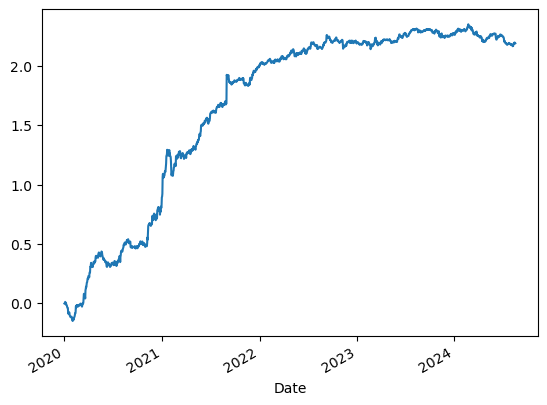

In [17]:
strat_net_ret = strat_net_ret_dict[0.1]
strat_net_ret.cumsum().plot()

The major drawback is that the performance has been steady during 2022-2024, even though the pairs are updated frequently.

We also compare the performance of our strategy against our benchmark, specifically a buy-and-hold strategy for Bitcoin. We will evaluate key metrics including alpha and beta, maximum drawdowns and maximum drawdown duration. 

In [18]:
buy_and_hold_btc = coins_ret['BTC'][start_of_out_sample:]
buy_and_hold_btc

Date
2020-01-01   -0.006253
2020-01-02   -0.000194
2020-01-03   -0.031958
2020-01-04    0.048320
2020-01-05    0.006990
                ...   
2024-08-12   -0.034218
2024-08-13    0.009282
2024-08-14    0.021081
2024-08-15   -0.030726
2024-08-16   -0.018984
Name: BTC, Length: 1692, dtype: float64

In [19]:
full_sample_ret = pd.DataFrame({
    'strat_ret': strat_net_ret,
    'buy_and_hold_btc': buy_and_hold_btc
})

full_sample_stats = compute_stats(full_sample_ret)
print(full_sample_stats)

                       avg       vol    sharpe  hit_rate
strat_ret         0.326556  0.208449  1.566602  0.524232
buy_and_hold_btc  0.439585  0.535531  0.820839  0.513626


<Axes: xlabel='Date'>

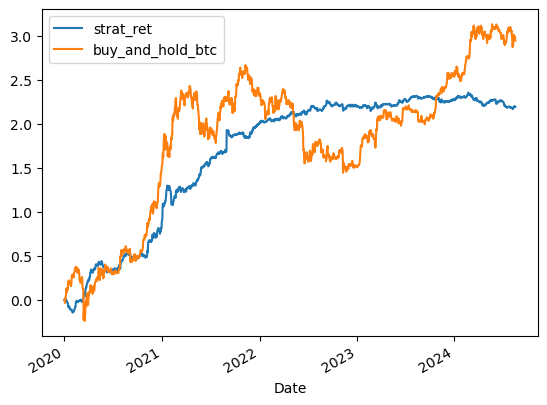

In [20]:
full_sample_ret.cumsum().plot()

In [21]:
corr = full_sample_ret.rolling(252).corr(full_sample_ret['buy_and_hold_btc'])
vol = full_sample_ret.rolling(252).std()

beta = (corr*vol).divide(vol['buy_and_hold_btc'], 0)

# Computing Point-in-Time Residual Returns
resid = full_sample_ret - beta.multiply(full_sample_ret['buy_and_hold_btc'], axis=0)
print(resid)
print(resid.corr())

# The information ratio
IR = resid.mean()/resid.std()*np.sqrt(252)
print(f"Information ratio is {IR['strat_ret']}")

           strat_ret  buy_and_hold_btc
Date                                  
2020-01-01       NaN               NaN
2020-01-02       NaN               NaN
2020-01-03       NaN               NaN
2020-01-04       NaN               NaN
2020-01-05       NaN               NaN
...              ...               ...
2024-08-12 -0.003478      1.457168e-16
2024-08-13   0.00932     -3.989864e-17
2024-08-14 -0.000546     -9.367507e-17
2024-08-15 -0.002998      1.353084e-16
2024-08-16  -0.00505      8.326673e-17

[1692 rows x 2 columns]
                  strat_ret  buy_and_hold_btc
strat_ret          1.000000          0.028531
buy_and_hold_btc   0.028531          1.000000
Information ratio is 1.2531577620603185


The correlation of the residual returns with Bitcoin is 0.0285, suggesting that the strategy captures true alpha

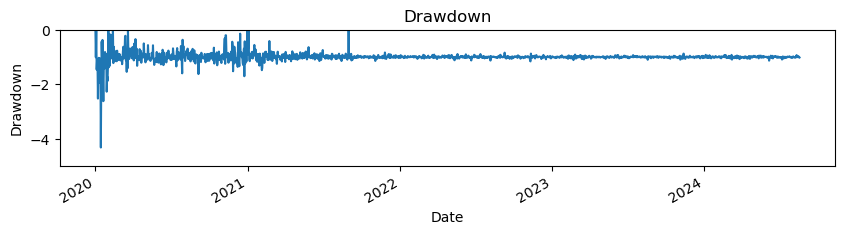

The max drawdown is -4.325608146626549


In [22]:
# Plot drawdown
dd = drawdown(full_sample_ret['strat_ret'])
plt.figure(figsize=(10, 2))
dd.plot()
plt.ylim(-5, 0)
plt.title('Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.show()
print(f"The max drawdown is {dd.min()}")

In [23]:
ddd = duration(full_sample_ret.cumsum())
ddd

,strat_ret,buy_and_hold_btc
Date,,
2020-01-01,0,0
2020-01-02,0,1
2020-01-03,1,2
2020-01-04,0,0
2020-01-05,1,0
...,...,...
2024-08-12,172,83
2024-08-13,173,84
2024-08-14,174,85


<Axes: xlabel='Date'>

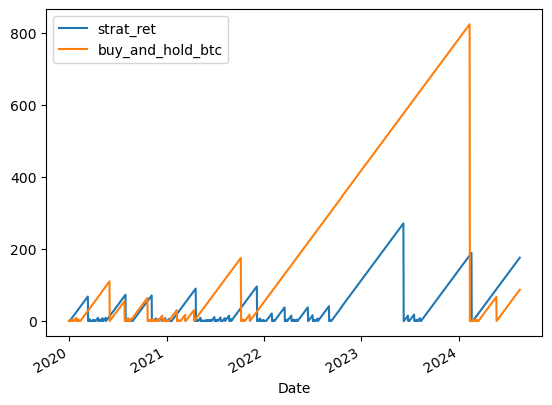

In [24]:
ddd.plot()

In [25]:
# maximum drawdown duration
ddd.max()

strat_ret           271
buy_and_hold_btc    824
dtype: object

**Conclusion:**

1. The correlation-based strategy outperforms the cointegration-based strategy.
2. Updating pairs every 3 months yields better performance, aligning with the fast-moving crypto market.
3. Selecting the top 3 to 5 pairs for each coin works better than choosing just the top pair.
